In [128]:
import os
import re
import numpy as np
from nltk.stem.porter import PorterStemmer
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

from utils import *

In [135]:
df = pd.read_csv("data_final.csv")

In [138]:
df.head()

,name_pp,lyric_pp,category
0,world cold,start pain followed hate fueled endless questi...,ROCK
1,broken,freedom alone alone patiently waiting phone ho...,ROCK
2,leaf loser,biting hand feed lying voice inside reach beg ...,ROCK
3,anthem underdog,say know going togine wait across line thought...,ROCK
4,adrenaline,heart beating faster control feeling anymore w...,ROCK


In [5]:
# we suppose the data in the train is combined by total files
def generate_vocabulary(dataframe):

    # compute inverse document frequency
    def compute_idf(df, corpus_size):
        # df stands for document frequency
        assert df > 0
        return np.log10(corpus_size * 1. / df)

    """
    doc_count is the list with keys are distince word in the
    vocabulary and the values is the number of document
    containing that word in the corpus
    """
    doc_count = defaultdict(int)
    corpus_size = dataframe.shape[0]
    print("Corpus size:", corpus_size)
    for line in df["lyric_pp"]:
        words = list(set(line.split()))
        for word in words:
            doc_count[word] += 1
    """
    words_idfs is list containing pairs of values - word and idf of that word
    under condition that the frequency is larger than 10
    """
    words_idfs = [(word, compute_idf(document_freq, corpus_size))
                for word, document_freq in zip(doc_count.keys(), doc_count.values())
                if document_freq > 10 and not word.isdigit()]
    words_idfs.sort(key=lambda x: -x[1])
    print("Vocabulary size {}". format(len(words_idfs)))
    with open('/Users/anhoang/Desktop/devzone/DS_project/words_idfs_final.txt', "w") as f:
        f.write("\n".join([word + "<fff>" + str(idf) for word, idf in words_idfs]))

In [6]:
generate_vocabulary(df)

Corpus size: 20339
Vocabulary size 8967


In [27]:
genresgroup_list = sorted(df["category"].unique())
genresgroup_list

['COUNTRY', 'HIPHOP', 'INDIE', 'JAZZ', 'POP', 'ROCK']

In [28]:
def get_tf_idf(dataframe):
    with open ("/Users/anhoang/Desktop/devzone/DS_project/words_idfs_final.txt") as f:
        word_idfs = [(line.split("<fff>")[0], float(line.split("<fff>")[1]))  
                    for line in f.read().splitlines()]

        idfs = dict(word_idfs)
        word_IDs = dict([(word, index) for index, (word, idf) in enumerate(word_idfs)])
    
    
    total_doc_num = dataframe.shape[0]
        
    data_tf_idf = []
    for i in range (total_doc_num):
        if i % 1000 == 0:
            print("Processing {i}-th/{total_doc_num} documents".format(i = i, total_doc_num = total_doc_num))
        # unpack document
        song_name, text, label = dataframe.iloc[i]
        words = [word for word in text.split() if word in idfs]
        word_set = list(set(words))

        max_term_freq = max([words.count(word) for word in word_set])
        words_tf_idf = []
        sum_squares = 0.0
        
        for word in word_set:
            term_freq = words.count(word)

            tf_idf_value = term_freq * 1. / max_term_freq * idfs[word]
            words_tf_idf.append((word_IDs[word], tf_idf_value))
            sum_squares = sum_squares + tf_idf_value ** 2
        
        words_tfidfs_normalized = [str(index)+":"+ str(tf_idf_value / np.sqrt(sum_squares))
                                for index, tf_idf_value in words_tf_idf]
        spare_rep = " ".join(words_tfidfs_normalized)
        data_tf_idf.append((genresgroup_list.index(label), i, spare_rep))
    with open('/Users/anhoang/Desktop/devzone/DS_project/data_tf_idf_final.txt', "w") as f:
        f.write("\n".join([str(label) + "<fff>" + str(i) + "<fff>" + spare_rep \
                            for label, i, spare_rep in data_tf_idf]))
    print("Already calculated tf-idf values of {} documents in the corpus. File was written and saved".format(total_doc_num))

In [29]:
get_tf_idf(df)

Processing 0-th/20339 documents
Processing 1000-th/20339 documents
Processing 2000-th/20339 documents
Processing 3000-th/20339 documents
Processing 4000-th/20339 documents
Processing 5000-th/20339 documents
Processing 6000-th/20339 documents
Processing 7000-th/20339 documents
Processing 8000-th/20339 documents
Processing 9000-th/20339 documents
Processing 10000-th/20339 documents
Processing 11000-th/20339 documents
Processing 12000-th/20339 documents
Processing 13000-th/20339 documents
Processing 14000-th/20339 documents
Processing 15000-th/20339 documents
Processing 16000-th/20339 documents
Processing 17000-th/20339 documents
Processing 18000-th/20339 documents
Processing 19000-th/20339 documents
Processing 20000-th/20339 documents
Already calculated tf-idf values of 20339 documents in the corpus. File was written and saved


In [30]:
def load_data(data_path):
    def sparse_to_dense(sparse_r_d, vocab_size):
        """
        Convert a sparse representation of a document by tf-idf to dense form
        by mapping its word to a new vector of vocabulary size.
        Word without any appearance in the doc get the value 0.0
        """
        r_d = [0.0 for _ in range(vocab_size)]
        indices_tf_idfs = sparse_r_d.split()
        for index_tf_idf in indices_tf_idfs:
            index = int(index_tf_idf.split(":")[0])
            tfidf = float(index_tf_idf.split(":")[1])
            r_d[index] = tfidf
        return np.array(r_d)
    with open(data_path) as f:
        d_lines = f.read().splitlines()
    with open("/Users/anhoang/Desktop/devzone/DS_project/words_idfs_final.txt") as f:
        vocab_size = len(f.read().splitlines())

    X = []
    Y = []
    label_count = defaultdict(int)
    for data_id, d in enumerate(d_lines):
        features = d.split("<fff>")
        label, doc_id = int(features[0]), int(features[1])
        label_count[label] += 1
        r_d = sparse_to_dense(
            sparse_r_d=features[2], vocab_size=vocab_size)
        X.append(r_d)
        Y.append(label)
    return X, Y

In [31]:
X, Y = load_data(data_path="data_tf_idf_final.txt")

In [32]:
np.array(X).shape

(20339, 8967)

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2023)

## Multinomial NB

In [74]:
from sklearn.naive_bayes import MultinomialNB

In [78]:
alpha_range = np.arange(0.01, 1, 0.02)

In [82]:
train_accuracy_lst = []
test_accuracy_lst = []
for alpha in alpha_range:
    clf = MultinomialNB(alpha=alpha)
    model = clf.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    test_accuracy_lst.append(accuracy_score(Y_test, Y_pred))
    Y_pred = model.predict(X_train)
    train_accuracy_lst.append(accuracy_score(Y_train, Y_pred))

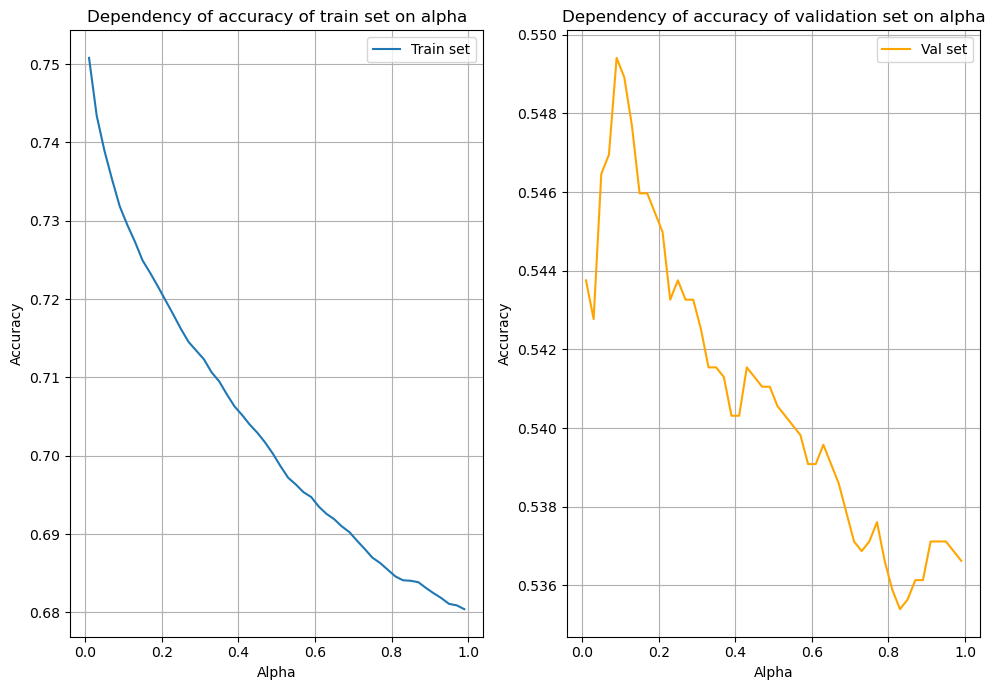

In [116]:
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, tight_layout = True)
ax0.plot(alpha_range, train_accuracy_lst)

ax0.set_xlabel("Alpha")
ax0.set_ylabel("Accuracy")
ax0.set_title("Dependency of accuracy of train set on alpha")
ax0.grid(True)
ax0.legend(["Train set"])


ax1.plot(alpha_range, test_accuracy_lst, color = "orange")
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Accuracy")
ax1.set_title("Dependency of accuracy of validation set on alpha")
ax1.legend(["Val set"])
ax1.grid(True)
plt.tight_layout()

plt.show()

In [115]:
print(max(test_accuracy_lst))
alpha_index = np.argmax(test_accuracy_lst)
print("index:", alpha_index)
print("alpha:", alpha_range[alpha_index])

0.549410029498525
index: 4
alpha: 0.08999999999999998


In [133]:
clf = MultinomialNB(alpha=0.09)
model = clf.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [122]:
accuracy_score(Y_test, Y_pred)

0.549410029498525

In [134]:
f1_score(Y_test, Y_pred, average="macro")

0.5445162329092873

In [123]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

In [124]:
def show_confusion_matrix(confusion_matrix):
    plt.rcParams["figure.figsize"] = (10,7)
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(genresgroup_list, rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(genresgroup_list, rotation=30, ha='right')
    plt.ylabel('True category')
    plt.xlabel('Predicted category');

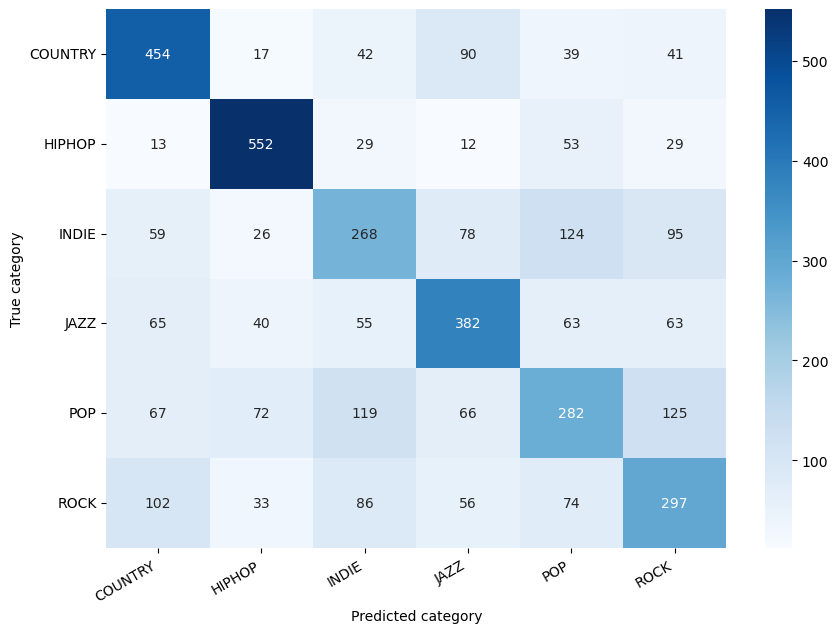

In [125]:
cfm = confusion_matrix(Y_test, Y_pred)
show_confusion_matrix(cfm)


## Linear SVM

In [40]:
from sklearn.metrics import classification_report

In [118]:
C_range = np.arange(0.001,0.2,0.005)
train_accuracy_lst = []
test_accuracy_lst = []
for C in C_range:
    
    classifier = LinearSVC(
    C = C, #penalty co-efficience
    tol = 1e-5, # tolerance for stopping criterion
    verbose = False # whether to print log or not
    )
    classifier.fit(csr_matrix(X_train), Y_train)

    Y_train_pred = classifier.predict(X_train)
    train_accuracy = accuracy_score(Y_train_pred, Y_train)
    train_accuracy_lst.append(train_accuracy)


    Y_test_pred = classifier.predict(X_test)
    test_accuracy = accuracy_score(Y_test_pred, Y_test)
    test_accuracy_lst.append(test_accuracy)

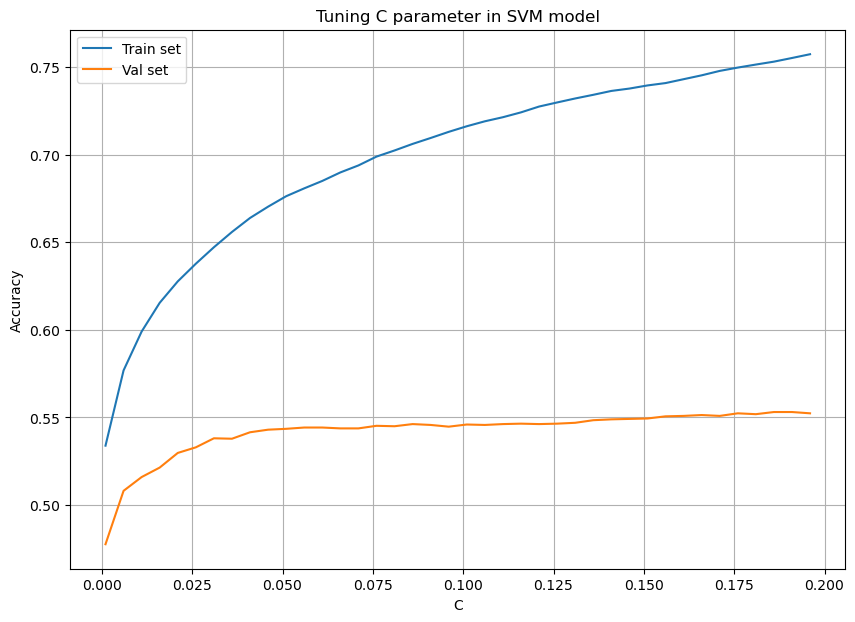

In [119]:
fig, ax = plt.subplots()
ax.plot(C_range, train_accuracy_lst)
ax.plot(C_range, test_accuracy_lst)
ax.set_xlabel("C")
ax.set_ylabel("Accuracy")
ax.set_title("Tuning C parameter in SVM model")
ax.legend(["Train set", "Val set"])
ax.grid(True)
plt.show()

In [45]:
print(max(test_accuracy_lst))
C_index = test_accuracy_lst.index(max(test_accuracy_lst))
print("Tuned value", C_range[C_index])

0.5530973451327433
Tuned value 0.186


In [126]:
classifier = LinearSVC(
    C = 0.186, #penalty co-efficience
)
classifier.fit(csr_matrix(X_train), Y_train)

Y_pred = classifier.predict(X_test)
accuracy = accuracy_score(Y_pred, Y_test)
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.5530973451327433


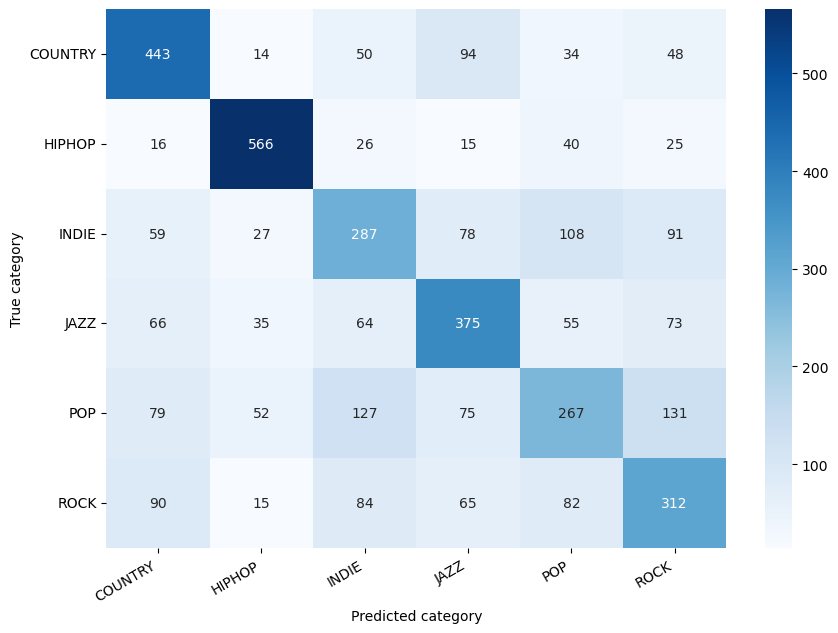

In [127]:
cfm = confusion_matrix(Y_test, Y_pred)
show_confusion_matrix(cfm)

In [130]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.59      0.65      0.62       683
           1       0.80      0.82      0.81       688
           2       0.45      0.44      0.45       650
           3       0.53      0.56      0.55       668
           4       0.46      0.37      0.41       731
           5       0.46      0.48      0.47       648

    accuracy                           0.55      4068
   macro avg       0.55      0.55      0.55      4068
weighted avg       0.55      0.55      0.55      4068



In [132]:
print(f1_score(Y_test, Y_pred, average = "macro"))

0.5492905606224757


## XGB

In [15]:
from xgboost import XGBClassifier

In [16]:
xgb_model = XGBClassifier(objective="multi:softprob", random_state=42)
xgb_model.fit(X_train, Y_train)
print("test")
Y_pred = xgb_model.predict(X_test)

print(confusion_matrix(Y_test, Y_pred))

test
[[419   3  45  92  56  68]
 [  7 552  23  19  56  31]
 [ 59  18 272  75 122 104]
 [ 68  31  76 363  66  64]
 [ 52  45 129  70 300 135]
 [ 72  14  79  68  82 333]]


In [17]:
accuracy = accuracy_score(Y_pred, Y_test)
print(accuracy)
print(f1_score(Y_pred, Y_test, average = "micro"))

0.55039331366765
0.55039331366765
